In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import json
from pandas import json_normalize
from tqdm.notebook import tqdm

import numpy as np
import ast
from typing import Dict, List

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../../'))

from core.fighters_utils import replace_null_height_to_arm_span, replace_null_arm_span_to_height
from core.events_utils import parse_odds, get_fighter_stats_cols, sum_round_stats, \
    parse_fight_data


pd.set_option('display.precision',6)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
fighters_df = pd.read_csv("../../data/0.fighters_raw.csv", index_col=0)
fighters_df["dateOfBirth"] = pd.to_datetime(fighters_df["dateOfBirth"])
fighters_cols = [
    "id",
    "name",
    "weight",
    "height",
    "armSpan",
    "legSwing",
    "weightCategory.id",
    "weightCategory.name",
    "dateOfBirth",
    "country",
    "city",
    "timezone",
]
fighters_df = fighters_df[fighters_cols]
fighters_df.set_index("id", inplace=True)
f_name_dict = fighters_df['name'].to_dict()

### Исправляем поле `country` для бойцов из США
# У некоторых бойцов из США в поле `country` указан штат, а не страна. \
# Также заменяем написание `United States` на `USA`, чтобы название соответствовало данным из таблицы с боями.

usa_state_names = [
    "Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut",
    "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho",
    "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine",
    "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", 
    "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", 
    "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", 
    "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", 
    "Wyoming",
]

fighters_df.loc[fighters_df["country"] == "United States", "country"] = "USA"
fighters_df.loc[fighters_df["country"].isin(usa_state_names), "country"] = "USA"


### Выбросы размаха ног меняем на NaN, для дальнейшей обработки
fighters_df.replace(fighters_df.legSwing.max(), np.nan, inplace=True)
fighters_df.replace(fighters_df.legSwing.min(), np.nan, inplace=True)

### Убираем строки с выбросами роста
fighters_df = fighters_df[fighters_df['height'] < 230]
fighters_df = fighters_df[fighters_df['height'] > 145]

### Убираем строки с выбросами веса
fighters_df = fighters_df[fighters_df['weight'] > 47]
fighters_df = fighters_df[fighters_df['weight'] < 250]

### Находим все возможные весовые категории
avg_weight_in_weight_category = fighters_df.groupby(by="weightCategory.id").mean()['weight']
avg_weight_in_weight_category

### Замена пустых значений роста на размах рук
fighters_df['height'] = fighters_df.apply(
    lambda row: replace_null_height_to_arm_span(row),
    axis=1
)

### Замена пустых значений размаха рук на рост
fighters_df['armSpan'] = fighters_df.apply(
    lambda row: replace_null_arm_span_to_height(row),
    axis=1
)

### Убираем пустые значения размаха ног, средним по колонке
fighters_df['legSwing'].fillna(np.round(fighters_df['legSwing'].mean(), 1), inplace=True)
fighters_df.to_csv('./data_models/fighters_df.csv')

## Предобработка данных о боях

In [3]:
events_df = pd.read_csv("../../data/0.events_raw.csv", index_col=0)
def balance_target(df):
    df = df.copy()
    print('percent of fighter1 winners BEFORE swapping indixes:', np.mean(df['winnerId'] == df['fighterId_1']))
    # randomly swap fighter1 and fighter2 for half of the dataset to create "negative cases"
    swap_indices = np.random.choice(len(df), size = len(df) // 2, replace = False)

    Fighter1_ColInd = np.where(df.columns == 'fighterId_1')[0][0]
    Fighter2_ColInd = np.where(df.columns == 'fighterId_2')[0][0]
    df.iloc[swap_indices, [Fighter1_ColInd, Fighter2_ColInd]] = df.iloc[swap_indices, [Fighter2_ColInd, Fighter1_ColInd]].values # swap fighters

    print('percent of fighter1 winners AFTER swapping indixes:', np.mean(df['winnerId'] == df['fighterId_1']))
    return df

events_df = balance_target(events_df)
events_df['winner'] = (events_df['winnerId'] == events_df['fighterId_1'])

### Убираем строки с незавершенными боями и боями, где отсутствует `winnerId`
events_df = events_df[events_df["completed"] == True]
events_df = events_df[~events_df["winnerId"].isna()]
events_df

percent of fighter1 winners BEFORE swapping indixes: 0.6435211267605634
percent of fighter1 winners AFTER swapping indixes: 0.476056338028169


,avgOdds,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,fighters,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner
0,[],Denver,True,USA,104.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1646,1923,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5201,http://www.ufcstats.com/fight-details/64139d1d...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True
0,[],Denver,True,USA,52.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1777,1883,"[{'fighterId': 1777, 'fightStats': {'hitsTotal...",5202,http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,True
0,[],Denver,True,USA,59.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1923,1908,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",5203,http://www.ufcstats.com/fight-details/ac7ca2ec...,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,True
0,[],Denver,True,USA,57.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1646,1631,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",5204,http://www.ufcstats.com/fight-details/ffd16691...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,True
0,[],Denver,True,USA,138.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1646,1924,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5205,http://www.ufcstats.com/fight-details/cecdc0da...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"[{'fighterId': 421, 'value': 1.46}, {'fighterI...",Las Vegas,True,USA,300.0,2021-02-27 00:00:00.000000,Europe/Berlin,3,421,668,"[{'fighterId': 421, 'fightStats': {'hitsTotal'...",40497,http://www.ufcstats.com/fight-details/3eac2d47...,UFC Fight Night,3.0,America/Los_Angeles,5,Легкий вес,['DEC'],668.0,False
0,"[{'fighterId': 3504, 'value': 1.56}, {'fighter...",Las Vegas,True,USA,158.0,2021-02-27 00:00:00.000000,Europe/Berlin,3,3521,3504,"[{'fighterId': 3504, 'fightStats': {'hitsTotal...",40498,http://www.ufcstats.com/fight-details/11a83369...,UFC Fight Night,3.0,America/Los_Angeles,3,Легчайший вес,['KO'],3504.0,False
0,"[{'fighterId': 1334, 'value': 1.63}, {'fighter...",Las Vegas,True,USA,300.0,2021-02-27 00:00:00.000000,Europe/Berlin,3,1334,3463,"[{'fighterId': 1334, 'fightStats': {'hitsTotal...",40500,http://www.ufcstats.com/fight-details/bc86601c...,UFC Fight Night,3.0,America/Los_Angeles,8,Полутяжелый вес,['DEC'],1334.0,True
0,"[{'fighterId': 246, 'value': 2.75}, {'fighterI...",Las Vegas,True,USA,208.0,2021-03-06 00:00:00.000000,Europe/Berlin,3,2073,246,"[{'fighterId': 246, 'fightStats': {'hitsTotal'...",40452,http://www.ufcstats.com/fight-details/7ad09f88...,UFC 259,3.0,America/Los_Angeles,6,Полусредний вес,['SUB'],2073.0,True


In [4]:
### Убираем строки, где `winnerId` не совпадает с айди ни одного из бойцов
events_df = events_df[~((events_df["winnerId"] != events_df["fighterId_1"]) & (events_df["winnerId"] != events_df["fighterId_2"]))]

### Удаляем лишние колонки
events_df.drop(
    columns=["completed", "eventDate.timezone_type", "link"],
    inplace=True,
)

### Извлекаем данные из колонок `avgOdds` и `fighters`
events_df[["f1_odds", "f2_odds"]] = events_df[["avgOdds", "fighterId_1", "fighterId_2"]]\
        .apply(lambda row: parse_odds(row), axis=1)

events_df = events_df.drop(columns="avgOdds")

#### Парсим колонку `fighters`
events_df[get_fighter_stats_cols()] = events_df[
    ["fighters", "fighterId_1", "fighterId_2"]
].apply(lambda row: parse_fight_data(row), axis=1)
events_df.drop(columns="fighters", inplace=True)
events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful
0,Denver,USA,104.0,1993-11-12 00:00:00.000000,Europe/Berlin,1646,1923,5201,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,Denver,USA,52.0,1993-11-12 00:00:00.000000,Europe/Berlin,1777,1883,5202,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,True,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0
0,Denver,USA,59.0,1993-11-12 00:00:00.000000,Europe/Berlin,1923,1908,5203,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,True,NaN,NaN,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
0,Denver,USA,57.0,1993-11-12 00:00:00.000000,Europe/Berlin,1646,1631,5204,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,True,NaN,NaN,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,Denver,USA,138.0,1993-11-12 00:00:00.000000,Europe/Berlin,1646,1924,5205,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Las Vegas,USA,300.0,2021-02-27 00:00:00.000000,Europe/Berlin,421,668,40497,UFC Fight Night,3.0,America/Los_Angeles,5,Легкий вес,['DEC'],668.0,False,1.46,2.84,63.0,17.0,0.0,0.0,0.0,0.0,63.0,17.0,0.0,0.0,45.0,6.0,10.0,3.0,8.0,8.0,63.0,17.0,0.0,0.0,0.0,0.0,71.0,16.0,0.0,0.0,0.0,0.0,71.0,16.0,0.0,0.0,62.0,12.0,3.0,1.0,6.0,3.0,71.0,16.0,0.0,0.0,0.0,0.0
0,Las Vegas,USA,158.0,2021-02-27 00:00:00.000000,Europe/Berlin,3521,3504,40498,UFC Fight Night,3.0,America/Los_Angeles,3,Легчайший вес,['KO'],3504.0,False,2.53,1.56,4.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,90.0,72.0,1.0,1.0,0.0,2.0,68.0,50.0,0.0,0.0,64.0,47.0,3.0,2.0,1.0,1.0,3.0,2.0,0.0,0.0,65.0,48.0
0,Las Vegas,USA,300.0,2021-02-27 00:00:00.000000,Europe/Berlin,1334,3463,40500,UFC Fight Night,3.0,America/Los_Angeles,8,Полутяжелый вес,['DEC'],1334.0,True,1.63,2.37,61.0,29.0,0.0,0.0,0.0,0.0,5

In [5]:
### Добавляем данные о бойцах в датафрейм с боями
fighter_data_cols = fighters_df.drop(columns=["weightCategory.id", "weightCategory.name"]).columns
# ['name', 'weight', 'height', 'armSpan', 'legSwing', 'dateOfBirth',
#        'country', 'city', 'timezone']

events_df = events_df.join(fighters_df[fighter_data_cols].add_prefix("f1_"), 
                           on="fighterId_1")

events_df = events_df.join(fighters_df[fighter_data_cols].add_prefix("f2_"), 
                           on="fighterId_2")

events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone
0,Denver,USA,104.0,1993-11-12 00:00:00.000000,Europe/Berlin,1646,1923,5201,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.70,1959-03-30,Netherlands,NaN,Europe/Amsterdam
0,Denver,USA,52.0,1993-11-12 00:00:00.000000,Europe/Berlin,1777,1883,5202,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,True,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.70,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.70,1970-01-01,USA,NaN,America/New_York
0,Denver,USA,59.0,1993-11-12 00:00:00.000000,Europe/Berlin,1923,1908,5203,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,True,NaN,NaN,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,Gerard Gordeau,97.98,195.58,195.58,101.70,1959-03-30,Netherlands,NaN,Europe/Amsterdam,Kevin Rosier,124.74,193.04,193.04,101.70,1970-01-01,USA,NaN,America/New_York
0,Denver,USA,57.0,1993-11-12 00:00:00.000000,Europe/Berlin,1646,1631,5204,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,True,NaN,NaN,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Ken Shamrock,92.99,185.42,182.88,101.70,1964-02-11,USA,Macon,America/New_York
0,Denver,USA,138.0,1993-11-12 00:00:00.000000,Europe/Berlin,1646,1924,5205,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Art Jimmerson,88.90,185.42,185.42,101.70,1963-08-04,USA,NaN,America/New_York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [6]:
### Добавляем признак `age`
def add_age(row: pd.Series) -> pd.Series:
    """
    Add age for both fighters.
    :param row: Row of the events dataframe.
    :return: pd.Series with age of fighters in years.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
#         try:
        age = row["eventDate.date"].year - row[prefix + "dateOfBirth"].year
#         except Exception:
#         age = np.nan
        result.append(age)
    return pd.Series(result)

def add_age2(row: pd.Series) -> pd.Series:
    """
    Add age for both fighters.
    :param row: Row of the events dataframe.
    :return: pd.Series with age of fighters in years.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        eventDate = row["eventDate.date"] 
        born = row[prefix + "dateOfBirth"]
        age = eventDate.year - born.year - ((eventDate.month, eventDate.day) < (born.month, born.day))
        result.append(age)
    return pd.Series(result)

events_df["eventDate.date"] = pd.to_datetime(events_df["eventDate.date"])
events_df["f1_dateOfBirth"] = pd.to_datetime(events_df["f1_dateOfBirth"])
events_df["f2_dateOfBirth"] = pd.to_datetime(events_df["f2_dateOfBirth"])
    
events_df[["f1_age", "f2_age"]] = events_df[["eventDate.date", "f1_dateOfBirth", "f2_dateOfBirth"]]\
    .apply(lambda row: add_age2(row), axis=1)

events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age
0,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,5201,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.70,1959-03-30,Netherlands,NaN,Europe/Amsterdam,26.0,34.0
0,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,5202,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,True,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.70,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.70,1970-01-01,USA,NaN,America/New_York,24.0,23.0
0,Denver,USA,59.0,1993-11-12,Europe/Berlin,1923,1908,5203,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,True,NaN,NaN,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,Gerard Gordeau,97.98,195.58,195.58,101.70,1959-03-30,Netherlands,NaN,Europe/Amsterdam,Kevin Rosier,124.74,193.04,193.04,101.70,1970-01-01,USA,NaN,America/New_York,34.0,23.0
0,Denver,USA,57.0,1993-11-12,Europe/Berlin,1646,1631,5204,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,True,NaN,NaN,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Ken Shamrock,92.99,185.42,182.88,101.70,1964-02-11,USA,Macon,America/New_York,26.0,29.0
0,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,5205,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Art Jimmerson,88.90,185.42,185.42,101.70,1963-08-04,USA,NaN,America/New_York,26.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [7]:
### TODO
### Добавляем признаки `isHomeCity`, `isHomeCountry`, `isHomeTimezone`
# Возможные значения переменных: 0 и 1 \
# `isHomeCity` - боец дерется в родном городе \
# `isHomeCountry` - боец дерется в родной стране \
# `isHomeTimezone` - боец дерется в своем часовом поясе

def get_territorial_cols() -> List[str]:
    """
    Get list of territorial column names for each fighter.
    :return: List of column names with 'f1_' prefix
    for the first fighter and 'f2_' prefix for the second.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        for key in ["isHomeCity", "isHomeCountry", "isHomeTimezone"]:
            result.append(prefix + key)
    return result


def fill_territorial_cols(row: pd.Series) -> pd.Series:
    """
    Add binary features 'isHomeCity', 'isHomeCountry', 'isHomeTimezone'
    for each fighter.
    :param row: Row of the events dataframe.
    :return: pd.Series with features for both fighters.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        for key in ["city", "country", "timezone"]:
            result.append(int(row[key] == row[prefix + key]))
    return pd.Series(result)

events_df[get_territorial_cols()] = events_df.apply(
    lambda row: fill_territorial_cols(row), axis=1
)
events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone
0,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,5201,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.70,1959-03-30,Netherlands,NaN,Europe/Amsterdam,26.0,34.0,0,0,0,0,0,0
0,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,5202,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,True,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.70,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.70,1970-01-01,USA,NaN,America/New_York,24.0,23.0,0,1,0,0,1,0
0,Denver,USA,59.0,1993-11-12,Europe/Berlin,1923,1908,5203,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,True,NaN,NaN,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,Gerard Gordeau,97.98,195.58,195.58,101.70,1959-03-30,Netherlands,NaN,Europe/Amsterdam,Kevin Rosier,124.74,193.04,193.04,101.70,1970-01-01,USA,NaN,America/New_York,34.0,23.0,0,0,0,0,1,0
0,Denver,USA,57.0,1993-11-12,Europe/Berlin,1646,1631,5204,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,True,NaN,NaN,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Ken Shamrock,92.99,185.42,182.88,101.70,1964-02-11,USA,Macon,America/New_York,26.0,29.0,0,0,0,0,1,0
0,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,5205,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,True,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.70,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Art Jimmerson,88.90,185.42,185.42,101.70,1963-08-04,USA,NaN,America/New_York,26

### Подготовка датафрэйма для кумулятивной суммы по статистике бойцов

In [8]:
events_df = events_df.reset_index()
stats_events_summary = events_df.copy()
stats_events_summary['winner_1'] = stats_events_summary['winnerId'] == stats_events_summary['fighterId_1'] 
stats_events_summary['winner_2'] = stats_events_summary['winnerId'] == stats_events_summary['fighterId_2'] 
stats_events_summary['winnerId'] = stats_events_summary['winnerId'] 
stats_events_summary = pd.get_dummies(stats_events_summary, columns = ['winMethods'], dtype=int)
stats_events_summary.columns = stats_events_summary.columns.str.replace('\'','')
fighter1_events = stats_events_summary[['eventDate.date','fighterId_1','duration','winner_1','f1_hitsTotal', 'f1_hitsSuccessful', 'f1_takedownTotal',
       'f1_takedownSuccessful', 'f1_submissionAttempts', 'f1_takeovers',
       'f1_accentedHitsTotal', 'f1_accentedHitsSuccessful', 'f1_knockdowns',
       'f1_protectionPassage', 'f1_hitsHeadTotal', 'f1_hitsHeadSuccessful',
       'f1_hitsBodyTotal', 'f1_hitsBodySuccessful', 'f1_hitsLegsTotal',
       'f1_hitsLegsSuccessful', 'f1_accentedHitsPositionDistanceTotal',
       'f1_accentedHitsPositionDistanceSuccessful',
       'f1_accentedHitsPositionClinchTotal',
       'f1_accentedHitsPositionClinchSuccessful',
       'f1_accentedHitsPositionParterTotal',
       'f1_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[SUB]', 'f1_odds', 'f1_age', 'winnerId']]
fighter1_events[['fighter_nbr']] = 1 # add what order was in event df

fighter2_events = stats_events_summary[['eventDate.date','fighterId_2','duration','winner_2','f2_hitsTotal',
       'f2_hitsSuccessful', 'f2_takedownTotal', 'f2_takedownSuccessful',
       'f2_submissionAttempts', 'f2_takeovers', 'f2_accentedHitsTotal',
       'f2_accentedHitsSuccessful', 'f2_knockdowns', 'f2_protectionPassage',
       'f2_hitsHeadTotal', 'f2_hitsHeadSuccessful', 'f2_hitsBodyTotal',
       'f2_hitsBodySuccessful', 'f2_hitsLegsTotal', 'f2_hitsLegsSuccessful',
       'f2_accentedHitsPositionDistanceTotal',
       'f2_accentedHitsPositionDistanceSuccessful',
       'f2_accentedHitsPositionClinchTotal',
       'f2_accentedHitsPositionClinchSuccessful',
       'f2_accentedHitsPositionParterTotal',
       'f2_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[SUB]', 'f2_odds', 'f2_age', 'winnerId']]
fighter2_events[['fighter_nbr']] = 2 # add what order was in event df

supl_cols = ['eventDate.date', 'fighterId', 'fighter_nbr', 'odds', 'age', 'winnerId']

current_col_names =  ['current_duration', 'winner', 'current_hitsTotal', 
             'current_hitsSuccessful',  'current_takedownTotal',  'current_takedownSuccessful', 
             'current_submissionAttempts',  'current_takeovers',  'current_accentedHitsTotal', 
             'current_accentedHitsSuccessful',  'current_knockdowns',  'current_protectionPassage', 
             'current_hitsHeadTotal',  'current_hitsHeadSuccessful',  'current_hitsBodyTotal', 
             'current_hitsBodySuccessful',  'current_hitsLegsTotal',  'current_hitsLegsSuccessful', 
             'current_accentedHitsPositionDistanceTotal', 'current_accentedHitsPositionDistanceSuccessful', 
             'current_accentedHitsPositionClinchTotal', 'current_accentedHitsPositionClinchSuccessful', 
             'current_accentedHitsPositionParterTotal', 'current_accentedHitsPositionParterSuccessful', 
             'current_winMethods_[DEC]', 'current_winMethods_[DQ]', 'current_winMethods_[KO]', 
             'current_winMethods_[SUB]']

_renamecols =  ['eventDate.date', 'fighterId', 'current_duration', 'winner', 'current_hitsTotal', 
             'current_hitsSuccessful',  'current_takedownTotal',  'current_takedownSuccessful', 
             'current_submissionAttempts',  'current_takeovers',  'current_accentedHitsTotal', 
             'current_accentedHitsSuccessful',  'current_knockdowns',  'current_protectionPassage', 
             'current_hitsHeadTotal',  'current_hitsHeadSuccessful',  'current_hitsBodyTotal', 
             'current_hitsBodySuccessful',  'current_hitsLegsTotal',  'current_hitsLegsSuccessful', 
             'current_accentedHitsPositionDistanceTotal', 'current_accentedHitsPositionDistanceSuccessful', 
             'current_accentedHitsPositionClinchTotal', 'current_accentedHitsPositionClinchSuccessful', 
             'current_accentedHitsPositionParterTotal', 'current_accentedHitsPositionParterSuccessful', 
             'current_winMethods_[DEC]', 'current_winMethods_[DQ]', 'current_winMethods_[KO]', 
             'current_winMethods_[SUB]', 'odds', 'age', 'winnerId', 'fighter_nbr']


fighter1_events.columns = _renamecols
fighter2_events.columns = _renamecols
f_stats_events_summ = pd.concat([fighter1_events, fighter2_events])
f_stats_events_summ.sort_values(by = ['fighterId','eventDate.date'], axis=0, inplace = True) # df with all firters ordered by ('fighterId','eventDate.date')
f_stats_events_summ[['eventDate.date']]

,eventDate.date
6266,2019-10-19 04:00:00
6353,2019-12-21 00:00:00
6532,2020-06-27 00:00:00
6585,2020-07-25 00:00:00
6733,2020-11-07 00:00:00
...,...
6820,2021-01-20 00:00:00
6806,2021-01-16 00:00:00
6836,2021-02-06 00:00:00
6813,2021-01-20 00:00:00


### Считаем накопительную статистику для всех бойцов:

In [9]:
def add_cumulative_sum (df:pd.DataFrame, current_col_names:List[str], supl_cols) -> pd.DataFrame:
    """
    Add cumulative sum for previous fights for input columns list to input df.
    :param df: input DF (should be sorted by fighter and date)
    :param columns: Column names of the dataframe.
    :return: pd.DataFrame with cumulative sum for previous fights for input columns list.
    """
    new_cumsum_colnames = []
    df_cumulative = pd.DataFrame(index=df.index)
    for column in current_col_names:
        if 'current_' in column:
            col_name = column.replace('current_', 'cumsum_')
        else:
            col_name = 'cumsum_' + column
            
        new_cumsum_colnames.append(col_name)
        df_cumulative[col_name] = df.groupby('fighterId')[column].cumsum() - f_stats_events_summ[column]
        
    df_cumulative[current_col_names+['age']] = df[current_col_names+['age']]
    df_cumulative[supl_cols] = df[supl_cols]

    return df_cumulative, new_cumsum_colnames

f_stats_events_cumulative, new_cumsum_colnames = add_cumulative_sum(f_stats_events_summ, current_col_names, supl_cols) # df c накопленной суммой
#count_of_fights
f_stats_events_cumulative['count_of_fights'] = f_stats_events_cumulative.groupby('fighterId')['fighter_nbr'].cumcount()
f_stats_events_cumulative

,cumsum_duration,cumsum_winner,cumsum_hitsTotal,cumsum_hitsSuccessful,cumsum_takedownTotal,cumsum_takedownSuccessful,cumsum_submissionAttempts,cumsum_takeovers,cumsum_accentedHitsTotal,cumsum_accentedHitsSuccessful,cumsum_knockdowns,cumsum_protectionPassage,cumsum_hitsHeadTotal,cumsum_hitsHeadSuccessful,cumsum_hitsBodyTotal,cumsum_hitsBodySuccessful,cumsum_hitsLegsTotal,cumsum_hitsLegsSuccessful,cumsum_accentedHitsPositionDistanceTotal,cumsum_accentedHitsPositionDistanceSuccessful,cumsum_accentedHitsPositionClinchTotal,cumsum_accentedHitsPositionClinchSuccessful,cumsum_accentedHitsPositionParterTotal,cumsum_accentedHitsPositionParterSuccessful,cumsum_winMethods_[DEC],cumsum_winMethods_[DQ],cumsum_winMethods_[KO],cumsum_winMethods_[SUB],current_duration,winner,current_hitsTotal,current_hitsSuccessful,current_takedownTotal,current_takedownSuccessful,current_submissionAttempts,current_takeovers,current_accentedHitsTotal,current_accentedHitsSuccessful,current_knockdowns,current_protectionPassage,current_hitsHeadTotal,current_hitsHeadSuccessful,current_hitsBodyTotal,current_hitsBodySuccessful,current_hitsLegsTotal,current_hitsLegsSuccessful,current_accentedHitsPositionDistanceTotal,current_accentedHitsPositionDistanceSuccessful,current_accentedHitsPositionClinchTotal,current_accentedHitsPositionClinchSuccessful,current_accentedHitsPositionParterTotal,current_accentedHitsPositionParterSuccessful,current_winMethods_[DEC],current_winMethods_[DQ],current_winMethods_[KO],current_winMethods_[SUB],age,eventDate.date,fighterId,fighter_nbr,odds,winnerId,count_of_fights
6266,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,300.0,True,51.0,35.0,0.0,0.0,0.0,0.0,51.0,35.0,0.0,0.0,25.0,11.0,15.0,15.0,11.0,9.0,51.0,35.0,0.0,0.0,0.0,0.0,0,0,0,0,28.0,2019-10-19 04:00:00,1,1,1.65,1.0,0
6353,300.0,1,51.0,35.0,0.0,0.0,0.0,0.0,51.0,35.0,0.0,0.0,25.0,11.0,15.0,15.0,11.0,9.0,51.0,35.0,0.0,0.0,0.0,0.0,0,0,0,0,300.0,False,37.0,13.0,0.0,0.0,0.0,0.0,37.0,13.0,0.0,0.0,30.0,6.0,3.0,3.0,4.0,4.0,37.0,13.0,0.0,0.0,0.0,0.0,0,0,0,0,28.0,2019-12-21 00:00:00,1,2,5.52,103.0,1
6532,600.0,1,88.0,48.0,0.0,0.0,0.0,0.0,88.0,48.0,0.0,0.0,55.0,17.0,18.0,18.0,15.0,13.0,88.0,48.0,0.0,0.0,0.0,0.0,0,0,0,0,161.0,True,22.0,15.0,0.0,0.0,0.0,0.0,22.0,15.0,0.0,1.0,12.0,6.0,2.0,2.0,8.0,7.0,21.0,14.0,0.0,0.0,1.0,1.0,0,0,1,0,28.0,2020-06-27 00:00:00,1,2,NaN,1.0,2
6585,761.0,2,110.0,63.0,0.0,0.0,0.0,0.0,110.0,63.0,0.0,1.0,67.0,23.0,20.0,20.0,23.0,20.0,109.0,62.0,0.0,0.0,1.0,1.0,0,0,1,0,156.0,True,36.0,28.0,0.0,0.0,0.0,0.0,36.0,28.0,0.0,0.0,20.0,12.0,6.0,6.0,10.0,10.0,24.0,19.0,0.0,0.0,12.0,9.0,0,0,1,0,28.0,2020-07-25 00:00:00,1,2,NaN,1.0,3
6733,917.0,3,146.0,91.0,0.0,0.0,0.0,0.0,146.0,91.0,0.0,1.0,87.0,35.0,26.0,26.0,33.0,30.0,133.0,81.0,0.0,0.0,13.0,10.0,0,0,2,0,300.0,False,55.0,29.0,0.0,0.0,0.0,0.0,55.0,29.0,0.0,0.0,30.0,7.0,3.0,1.0,22.0,21.0,54.0,29.0,1.0,0.0,0.0,0.0,1,0,0,0,29.0,2020-11-07 00:00:00,1,1,1.29,277.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,248.0,True,49.0,25.0,1.0,1.0,0.0,0.0,45.0,21.0,0.0,0.0,38.0,17.0,4.0,2.0,3.0,2.0,40.0,20.0,2.0,0.0,3.0,1.0,0,0,1,0,30.0,2021-01-20 00:00:00,3664,1,1.50,3664.0,0
6806,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,300.0,True,93.0,42.0,2.0,0.0,0.0,0.0,93.0,42.0,0.0,0.0,47.0,13.0,26.0,15.0,20.0,14.0,90.0,41.0,3.0,1.0,0.0,0.0,1,0,0,0,25.0,2021-01-16 00:00:00,3666,1,1.93,3666.0,0
6836,300.0,1,93.0,42.0,2.0,0.0,0.0,0.0,93.0,42.0,0.0,0.0,47.0,13.0,26.0,15.0,20.0,14.0,90.0,41.0,3.0,1.0,0.0,0.0,1,0,0,0,300.0,False,40.0,30.0,1.0,0.0,0.0,0.0,14.0,8.0,0.0,0.0,8.0,4.0,1.0,0.0,5.0,4.0,10.0,5.0,1.0,1.0,3.0,2.0,1,0,0,0,25.0,20

# Feature engineering

In [10]:
### Calculate accuracy cols
for_accuracy_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 'accentedHitsPositionDistance', 
 'accentedHitsPositionClinch', 'accentedHitsPositionParter']
new_accuracy_cols = []
for col in for_accuracy_cols:
    new_accuracy_col = f'{col}_accuracy' 
    
    new_accuracy_cols.append(new_accuracy_col)
    f_stats_events_cumulative[new_accuracy_col] = f_stats_events_cumulative[f'cumsum_{col}Successful']/f_stats_events_cumulative[f'cumsum_{col}Total']

    
### Calculate winpersent cols
for_percent_cols = ['DEC', 'DQ', 'KO', 'SUB']
new_percent_cols = []
for col in for_percent_cols:
    new_percent_col = f'{col}_percent' 
    new_percent_cols.append(new_percent_col)
    f_stats_events_cumulative[new_percent_col] = f_stats_events_cumulative[f'cumsum_winMethods_[{col}]']/f_stats_events_cumulative['cumsum_winner']


### Calculate Per minute cols
for_PM_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 
               'accentedHitsPositionDistance', 'accentedHitsPositionClinch', 'accentedHitsPositionParter']

new_PM_cols = []
for col in for_PM_cols:
    new_PM_col = f'{col}_PM' 
    new_PM_cols.append(new_PM_col)
    f_stats_events_cumulative[new_PM_col]  = f_stats_events_cumulative[f'cumsum_{col}Successful']/f_stats_events_cumulative['cumsum_duration']*60

    
# knockdowns per minute
new_PM_col = 'knockdowns_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative[new_PM_col]  = f_stats_events_cumulative['cumsum_knockdowns']/f_stats_events_cumulative['cumsum_duration']*60


# protectionPassage per minute
new_PM_col = 'protectionPassage_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative[new_PM_col]  = f_stats_events_cumulative['cumsum_protectionPassage']/f_stats_events_cumulative['cumsum_duration']*60


# Win and Loose streak
def calculate_win_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'eventDate.date'
        streaks.append(0)
        
        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            
            if fighterId == winnerId:
                curr_streak += 1
            else:
                curr_streak = 0

            streaks.append(curr_streak)

    return streaks

def calculate_loose_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'fighter_nbr'
        streaks.append(0)

        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            if fighterId == winnerId:
                curr_streak = 0
            else:
                curr_streak += 1

            streaks.append(curr_streak)

    return streaks

win_streaks = calculate_win_streak(f_stats_events_cumulative)
f_stats_events_cumulative['win_streak'] = win_streaks
f_stats_events_cumulative['win_streak'] = f_stats_events_cumulative['win_streak'] #- f_stats_events_cumulative['winner']

loose_streaks = calculate_loose_streak(f_stats_events_cumulative)
f_stats_events_cumulative['loose_streak'] = loose_streaks
f_stats_events_cumulative['loose_streak'] = f_stats_events_cumulative['loose_streak'] #- ~f_stats_events_cumulative['winner']

new_streak_cols = ['win_streak', 'loose_streak']

current_col_names,  new_PM_cols, new_accuracy_cols, new_percent_cols, new_streak_cols

  0%|          | 0/2653 [00:00<?, ?it/s]

  0%|          | 0/2653 [00:00<?, ?it/s]

(['current_duration',
  'winner',
  'current_hitsTotal',
  'current_hitsSuccessful',
  'current_takedownTotal',
  'current_takedownSuccessful',
  'current_submissionAttempts',
  'current_takeovers',
  'current_accentedHitsTotal',
  'current_accentedHitsSuccessful',
  'current_knockdowns',
  'current_protectionPassage',
  'current_hitsHeadTotal',
  'current_hitsHeadSuccessful',
  'current_hitsBodyTotal',
  'current_hitsBodySuccessful',
  'current_hitsLegsTotal',
  'current_hitsLegsSuccessful',
  'current_accentedHitsPositionDistanceTotal',
  'current_accentedHitsPositionDistanceSuccessful',
  'current_accentedHitsPositionClinchTotal',
  'current_accentedHitsPositionClinchSuccessful',
  'current_accentedHitsPositionParterTotal',
  'current_accentedHitsPositionParterSuccessful',
  'current_winMethods_[DEC]',
  'current_winMethods_[DQ]',
  'current_winMethods_[KO]',
  'current_winMethods_[SUB]'],
 ['hits_PM',
  'takedown_PM',
  'accentedHits_PM',
  'hitsHead_PM',
  'hitsBody_PM',
  'hitsLe

In [11]:
q = f_stats_events_cumulative[(f_stats_events_cumulative['fighterId'] == 347)]

q[['winner', 'fighterId', 'winnerId', 'win_streak', 'loose_streak', 'eventDate.date', 'fighter_nbr']][:50].sort_values('eventDate.date')

,winner,fighterId,winnerId,win_streak,loose_streak,eventDate.date,fighter_nbr
1645,True,347,347.0,0,0,2008-11-05 00:00:00,1
2376,True,347,347.0,1,0,2010-12-16 00:00:00,1
2418,True,347,347.0,2,0,2011-02-05 00:00:00,2
2533,True,347,347.0,3,0,2011-06-11 00:00:00,1
2592,True,347,347.0,4,0,2011-08-14 00:00:00,2
2676,True,347,347.0,5,0,2011-10-29 00:00:00,2
2751,False,347,129.0,6,0,2011-12-30 00:00:00,2
2878,True,347,347.0,0,1,2012-05-15 00:00:00,2
2989,True,347,347.0,1,0,2012-08-11 00:00:00,2
3131,False,347,292.0,2,0,2013-01-26 00:00:00,1


# Prepare data for training and validation

In [12]:
static_supl_cols = ['city', 'country', 'duration',
            'fighterId_1', 'fighterId_2', 'name', 'rounds', 'eventDate.date', 'weightCategory.name',
            'winnerId', 'f1_odds', 'f2_odds',  'f1_age', 'f2_age', 'f1_count_of_fights', 'f2_count_of_fights']

f1_cumsum_col_names = ['f1_' + i for i in new_cumsum_colnames]
f2_cumsum_col_names = ['f2_' + i for i in new_cumsum_colnames]


all_new_cols={
    'static_supl_cols': static_supl_cols,
    'f2_cumsum_col_names':f2_cumsum_col_names,
    'f1_cumsum_col_names':f1_cumsum_col_names,
    'new_cumsum_colnames':new_cumsum_colnames,
    'new_accuracy_cols':new_accuracy_cols,
    'new_percent_cols':new_percent_cols,
    'new_PM_cols':new_PM_cols, 
    'new_streak_cols':new_streak_cols,
     } 
            
    
all_fightCols_list = all_new_cols['new_cumsum_colnames']+all_new_cols['new_accuracy_cols']+\
    all_new_cols['new_percent_cols']+all_new_cols['new_PM_cols']+all_new_cols['new_streak_cols'] + \
    ['count_of_fights'] 

In [13]:
events_df_joined = events_df.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 1]\
        [all_fightCols_list].add_prefix("f1_")) #, on="id"

events_df_joined = events_df_joined.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 2]\
        [all_fightCols_list].add_prefix("f2_"))

events_df_joined#.head(5)

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClin

In [14]:
all_fightCols_list

['cumsum_duration',
 'cumsum_winner',
 'cumsum_hitsTotal',
 'cumsum_hitsSuccessful',
 'cumsum_takedownTotal',
 'cumsum_takedownSuccessful',
 'cumsum_submissionAttempts',
 'cumsum_takeovers',
 'cumsum_accentedHitsTotal',
 'cumsum_accentedHitsSuccessful',
 'cumsum_knockdowns',
 'cumsum_protectionPassage',
 'cumsum_hitsHeadTotal',
 'cumsum_hitsHeadSuccessful',
 'cumsum_hitsBodyTotal',
 'cumsum_hitsBodySuccessful',
 'cumsum_hitsLegsTotal',
 'cumsum_hitsLegsSuccessful',
 'cumsum_accentedHitsPositionDistanceTotal',
 'cumsum_accentedHitsPositionDistanceSuccessful',
 'cumsum_accentedHitsPositionClinchTotal',
 'cumsum_accentedHitsPositionClinchSuccessful',
 'cumsum_accentedHitsPositionParterTotal',
 'cumsum_accentedHitsPositionParterSuccessful',
 'cumsum_winMethods_[DEC]',
 'cumsum_winMethods_[DQ]',
 'cumsum_winMethods_[KO]',
 'cumsum_winMethods_[SUB]',
 'hits_accuracy',
 'takedown_accuracy',
 'accentedHits_accuracy',
 'hitsHead_accuracy',
 'hitsBody_accuracy',
 'hitsLegs_accuracy',
 'accentedH

In [15]:
event_cols = ['city', 'country', 'duration', 'eventDate.date',
'eventDate.timezone', 'fighterId_1', 'fighterId_2', 'id', 'name',
'rounds', 'timezone', 'weightCategory.id', 'weightCategory.name',
'winMethods', 'winnerId', 
'f1_name', 'f2_name', 
'f1_odds', 'f2_odds', 
'f1_age', 'f2_age',
'f1_height', 'f2_height', 
'f1_armSpan', 'f2_armSpan', 
'f1_legSwing', 'f2_legSwing', 
'f1_country', 'f2_country', 
'f1_city', 'f2_city', 
'f1_timezone', 'f2_timezone', 
'f1_isHomeCity', 'f2_isHomeCity',
'f1_isHomeCountry', 'f2_isHomeCountry', 
'f1_isHomeTimezone', 'f2_isHomeTimezone']
# 'f1_weight','f2_weight',

events = events_df[event_cols]

events_joined_straight = events.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 1]\
        [all_fightCols_list].add_prefix("f1_")) #, on="id"

events_joined_straight = events_joined_straight.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 2]\
        [all_fightCols_list].add_prefix("f2_"))

events_joined_straight['type'] = 'straight'
events_joined_straight#.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type
0,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,5201,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,Royce Gracie,Gerard Gordeau,NaN,NaN,26.0,34.0,185.42,195.58,185.42,195.58,101.70,101.70,Brazil,Netherlands,Rio de Janeiro,NaN,America/Sao_Paulo,Europe/Amsterdam,0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,85.0,2,22.0,14.0,0.0,0.0,0.0,0.0,22.0,14.0,0.0,0.0,18.0,10.0,1.0,1.0,3.0,3.0,11.0,6.0,0.0,0.0,11.0,8.0,0,0,2,0,0.636364,NaN,0.636364,0.555556,1.000000,1.000000,0.545455,NaN,0.727273,0.000000,0.0,1.0,0.000000,9.882353,0.000000,9.882353,7.058824,

In [16]:
fight_stats = new_cumsum_colnames + new_accuracy_cols + new_percent_cols + new_PM_cols + new_streak_cols
other_stats = ['odds', 'age', 'height', 'armSpan', 'legSwing', 'isHomeCity', 'isHomeCountry',  'isHomeTimezone']
cols_for_difference = fight_stats + other_stats

fighter1_stats = pd.Series(cols_for_difference).apply(lambda x: 'f1_'+x).tolist()
fighter2_stats = pd.Series(cols_for_difference).apply(lambda x: 'f2_'+x).tolist()


difference_cols = []
for col in cols_for_difference:
    new_col_name = col+'_difference'
    difference_cols.append(new_col_name)
    events_joined_straight[new_col_name] = events_joined_straight['f1_'+col].astype(float) - events_joined_straight['f2_'+col].astype(float)
fight_stats += difference_cols
events_joined_straight[difference_cols]

,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_[DEC]_difference,cumsum_winMethods_[DQ]_difference,cumsum_winMethods_[KO]_difference,cumsum_winMethods_[SUB]_difference,hits_accuracy_difference,takedown_accuracy_difference,accentedHits_accuracy_difference,hitsHead_accuracy_difference,hitsBody_accuracy_difference,hitsLegs_accuracy_difference,accentedHitsPositionDistance_accuracy_difference,accentedHitsPositionClinch_accuracy_difference,accentedHitsPositionParter_accuracy_difference,DEC_percent_difference,DQ_percent_difference,KO_percent_difference,SUB_percent_difference,hits_PM_difference,takedown_PM_difference,accentedHits_PM_difference,hitsHead_PM_difference,hitsBody_PM_difference,hitsLegs_PM_difference,accentedHitsPositionDistance_PM_difference,accentedHitsPositionClinch_PM_difference,accentedHitsPositionParter_PM_difference,knockdowns_PM_difference,protectionPassage_PM_difference,win_streak_difference,loose_streak_difference,odds_difference,age_difference,height_difference,armSpan_difference,legSwing_difference,isHomeCity_difference,isHomeCountry_difference,isHomeTimezone_difference
0,-85.0,-2.0,-22.0,-14.0,0.0,0.0,0.0,0.0,-22.0,-14.0,0.0,0.0,-18.0,-10.0,-1.0,-1.0,-3.0,-3.0,-11.0,-6.0,0.0,0.0,-11.0,-8.0,0.0,0.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,0.0,NaN,-8.0,-10.16,-10.16,0.00,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,-7.62,-7.62,0.00,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,11.0,2.54,2.54,0.00,0.0,-1.0,0.0
3,104.0,1.0,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,-3.0,0.00,2.54,0.00,0.0,-1.0,0.0
4,161.0,2.0,16.0,15.0,4.0,1.0,2.0,1.0,2.0,1.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,-4.0,0.00,0.00,0.00,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,11.0,1.0,75.0,29.0,1.0,1.0,-3.0,0.0,88.0,43.0,0.0,0.0,46.0,16.0,38.0,24.0,4.0,3.0,75.0,41.0,15.0,8.0,-2.0,-6.0,-2.0,0.0,4.0,-1.0,-0.047505,0.071429,0.023285,-0.008940,0.061466,-0.042857,0.094331,-0.388889,-0.187826,-0.833333,0.0,1.0,-0.333333,1.363305,0.047236,2.062096,0.757519,1.162869,0.141708,1.975471,0.387042,-0.300416,0.0,-0.001308,-1.0,0.0,-1.38,3.0,0.00,5.08,-1.37,0.0,1.0,0.0
6873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [17]:
events_joined_reversed = events_joined_straight.copy()
reversed_cols = []

for col in events_joined_reversed.columns:
    if 'f2' in col:
        new_col_name = col.replace('f2', 'f1')

    elif 'f1' in col:
        new_col_name = col.replace('f1', 'f2')
    
    else: new_col_name = col
        
    reversed_cols.append(new_col_name)
events_joined_reversed.columns = reversed_cols
events_joined_reversed = events_joined_reversed.rename(columns={
                             'fighterId_1':'fighterId_2',
                             'fighterId_2':'fighterId_1',
                            })
events_joined_reversed['type'] = 'reversed'

difference_cols = []
for col in cols_for_difference:
    new_col_name = col+'_difference'
    difference_cols.append(new_col_name)
    events_joined_reversed[new_col_name] = events_joined_reversed['f1_'+col].astype(float) - events_joined_reversed['f2_'+col].astype(float)
fight_stats += difference_cols
events_joined_reversed[difference_cols]

,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_[DEC]_difference,cumsum_winMethods_[DQ]_difference,cumsum_winMethods_[KO]_difference,cumsum_winMethods_[SUB]_difference,hits_accuracy_difference,takedown_accuracy_difference,accentedHits_accuracy_difference,hitsHead_accuracy_difference,hitsBody_accuracy_difference,hitsLegs_accuracy_difference,accentedHitsPositionDistance_accuracy_difference,accentedHitsPositionClinch_accuracy_difference,accentedHitsPositionParter_accuracy_difference,DEC_percent_difference,DQ_percent_difference,KO_percent_difference,SUB_percent_difference,hits_PM_difference,takedown_PM_difference,accentedHits_PM_difference,hitsHead_PM_difference,hitsBody_PM_difference,hitsLegs_PM_difference,accentedHitsPositionDistance_PM_difference,accentedHitsPositionClinch_PM_difference,accentedHitsPositionParter_PM_difference,knockdowns_PM_difference,protectionPassage_PM_difference,win_streak_difference,loose_streak_difference,odds_difference,age_difference,height_difference,armSpan_difference,legSwing_difference,isHomeCity_difference,isHomeCountry_difference,isHomeTimezone_difference
0,85.0,2.0,22.0,14.0,0.0,0.0,0.0,0.0,22.0,14.0,0.0,0.0,18.0,10.0,1.0,1.0,3.0,3.0,11.0,6.0,0.0,0.0,11.0,8.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,8.0,10.16,10.16,0.00,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-1.0,7.62,7.62,0.00,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-11.0,-2.54,-2.54,0.00,0.0,1.0,0.0
3,-104.0,-1.0,-4.0,-3.0,-3.0,-1.0,-1.0,0.0,-2.0,-1.0,0.0,-2.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,NaN,3.0,0.00,-2.54,0.00,0.0,1.0,0.0
4,-161.0,-2.0,-16.0,-15.0,-4.0,-1.0,-2.0,-1.0,-2.0,-1.0,0.0,-4.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,0.0,NaN,4.0,0.00,0.00,0.00,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,-11.0,-1.0,-75.0,-29.0,-1.0,-1.0,3.0,0.0,-88.0,-43.0,0.0,0.0,-46.0,-16.0,-38.0,-24.0,-4.0,-3.0,-75.0,-41.0,-15.0,-8.0,2.0,6.0,2.0,0.0,-4.0,1.0,0.047505,-0.071429,-0.023285,0.008940,-0.061466,0.042857,-0.094331,0.388889,0.187826,0.833333,0.0,-1.0,0.333333,-1.363305,-0.047236,-2.062096,-0.757519,-1.162869,-0.141708,-1.975471,-0.387042,0.300416,0.0,0.001308,1.0,0.0,1.38,-3.0,0.00,-5.08,1.37,0.0,-1.0,0.0
6873,0.0,0.0,0.0,0.0,0.0,0

In [18]:
# Join
events_joined_total = events_joined_straight.append(events_joined_reversed)
events_joined_total['winner'] = events_joined_total['winnerId'] == events_joined_total['fighterId_1']
events_joined_total['is_fight_night'] = events_joined_total['name'].apply(lambda x: 'Fight Night' in x)

events_joined_total

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionCl

In [19]:
# # Save data for training
import json

generated_features = {}
generated_features['fighter1_stats'] = fighter1_stats
generated_features['fighter2_stats'] = fighter2_stats
generated_features['difference_cols'] = difference_cols

with open('./data_models/generated_features_08.04.2021.txt', 'w') as outfile:
    json.dump(generated_features, outfile)
    
events_joined_total.to_csv('./data_models/events_joined_total_08.04.2021.csv')
events_joined_total.shape

(13754, 214)

<AxesSubplot:>

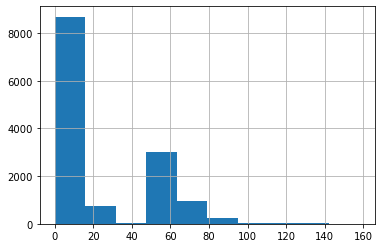

In [20]:
events_joined_total.isna().sum(axis=1).hist()

# PROD data preparation

In [21]:
def add_cumulative_sum_prod(df:pd.DataFrame, current_col_names:List[str], supl_cols) -> pd.DataFrame:
    """
    Add cumulative sum for previous fights for input columns list to input df.
    :param df: input DF (should be sorted by fighter and date)
    :param columns: Column names of the dataframe.
    :return: pd.DataFrame with cumulative sum for previous fights for input columns list.
    """
    new_cumsum_colnames = []
    df_cumulative = pd.DataFrame(index=df.index)
    for column in current_col_names:
        if 'current_' in column:
            col_name = column.replace('current_', 'cumsum_')
        else:
            col_name = 'cumsum_' + column
            
        new_cumsum_colnames.append(col_name)
        df_cumulative[col_name] = df.groupby('fighterId')[column].cumsum()
        
    df_cumulative[current_col_names+['age']] = df[current_col_names+['age']]
    df_cumulative[supl_cols] = df[supl_cols]

    return df_cumulative, new_cumsum_colnames

f_stats_events_cumulative_prod, new_cumsum_colnames = add_cumulative_sum_prod(f_stats_events_summ, current_col_names, supl_cols) # df c накопленной суммой
#count_of_fights
f_stats_events_cumulative_prod['count_of_fights'] = f_stats_events_cumulative_prod.groupby('fighterId')['fighter_nbr'].cumcount()
f_stats_events_cumulative_prod

,cumsum_duration,cumsum_winner,cumsum_hitsTotal,cumsum_hitsSuccessful,cumsum_takedownTotal,cumsum_takedownSuccessful,cumsum_submissionAttempts,cumsum_takeovers,cumsum_accentedHitsTotal,cumsum_accentedHitsSuccessful,cumsum_knockdowns,cumsum_protectionPassage,cumsum_hitsHeadTotal,cumsum_hitsHeadSuccessful,cumsum_hitsBodyTotal,cumsum_hitsBodySuccessful,cumsum_hitsLegsTotal,cumsum_hitsLegsSuccessful,cumsum_accentedHitsPositionDistanceTotal,cumsum_accentedHitsPositionDistanceSuccessful,cumsum_accentedHitsPositionClinchTotal,cumsum_accentedHitsPositionClinchSuccessful,cumsum_accentedHitsPositionParterTotal,cumsum_accentedHitsPositionParterSuccessful,cumsum_winMethods_[DEC],cumsum_winMethods_[DQ],cumsum_winMethods_[KO],cumsum_winMethods_[SUB],current_duration,winner,current_hitsTotal,current_hitsSuccessful,current_takedownTotal,current_takedownSuccessful,current_submissionAttempts,current_takeovers,current_accentedHitsTotal,current_accentedHitsSuccessful,current_knockdowns,current_protectionPassage,current_hitsHeadTotal,current_hitsHeadSuccessful,current_hitsBodyTotal,current_hitsBodySuccessful,current_hitsLegsTotal,current_hitsLegsSuccessful,current_accentedHitsPositionDistanceTotal,current_accentedHitsPositionDistanceSuccessful,current_accentedHitsPositionClinchTotal,current_accentedHitsPositionClinchSuccessful,current_accentedHitsPositionParterTotal,current_accentedHitsPositionParterSuccessful,current_winMethods_[DEC],current_winMethods_[DQ],current_winMethods_[KO],current_winMethods_[SUB],age,eventDate.date,fighterId,fighter_nbr,odds,winnerId,count_of_fights
6266,300.0,1,51.0,35.0,0.0,0.0,0.0,0.0,51.0,35.0,0.0,0.0,25.0,11.0,15.0,15.0,11.0,9.0,51.0,35.0,0.0,0.0,0.0,0.0,0,0,0,0,300.0,True,51.0,35.0,0.0,0.0,0.0,0.0,51.0,35.0,0.0,0.0,25.0,11.0,15.0,15.0,11.0,9.0,51.0,35.0,0.0,0.0,0.0,0.0,0,0,0,0,28.0,2019-10-19 04:00:00,1,1,1.65,1.0,0
6353,600.0,1,88.0,48.0,0.0,0.0,0.0,0.0,88.0,48.0,0.0,0.0,55.0,17.0,18.0,18.0,15.0,13.0,88.0,48.0,0.0,0.0,0.0,0.0,0,0,0,0,300.0,False,37.0,13.0,0.0,0.0,0.0,0.0,37.0,13.0,0.0,0.0,30.0,6.0,3.0,3.0,4.0,4.0,37.0,13.0,0.0,0.0,0.0,0.0,0,0,0,0,28.0,2019-12-21 00:00:00,1,2,5.52,103.0,1
6532,761.0,2,110.0,63.0,0.0,0.0,0.0,0.0,110.0,63.0,0.0,1.0,67.0,23.0,20.0,20.0,23.0,20.0,109.0,62.0,0.0,0.0,1.0,1.0,0,0,1,0,161.0,True,22.0,15.0,0.0,0.0,0.0,0.0,22.0,15.0,0.0,1.0,12.0,6.0,2.0,2.0,8.0,7.0,21.0,14.0,0.0,0.0,1.0,1.0,0,0,1,0,28.0,2020-06-27 00:00:00,1,2,NaN,1.0,2
6585,917.0,3,146.0,91.0,0.0,0.0,0.0,0.0,146.0,91.0,0.0,1.0,87.0,35.0,26.0,26.0,33.0,30.0,133.0,81.0,0.0,0.0,13.0,10.0,0,0,2,0,156.0,True,36.0,28.0,0.0,0.0,0.0,0.0,36.0,28.0,0.0,0.0,20.0,12.0,6.0,6.0,10.0,10.0,24.0,19.0,0.0,0.0,12.0,9.0,0,0,1,0,28.0,2020-07-25 00:00:00,1,2,NaN,1.0,3
6733,1217.0,3,201.0,120.0,0.0,0.0,0.0,0.0,201.0,120.0,0.0,1.0,117.0,42.0,29.0,27.0,55.0,51.0,187.0,110.0,1.0,0.0,13.0,10.0,1,0,2,0,300.0,False,55.0,29.0,0.0,0.0,0.0,0.0,55.0,29.0,0.0,0.0,30.0,7.0,3.0,1.0,22.0,21.0,54.0,29.0,1.0,0.0,0.0,0.0,1,0,0,0,29.0,2020-11-07 00:00:00,1,1,1.29,277.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,248.0,1,49.0,25.0,1.0,1.0,0.0,0.0,45.0,21.0,0.0,0.0,38.0,17.0,4.0,2.0,3.0,2.0,40.0,20.0,2.0,0.0,3.0,1.0,0,0,1,0,248.0,True,49.0,25.0,1.0,1.0,0.0,0.0,45.0,21.0,0.0,0.0,38.0,17.0,4.0,2.0,3.0,2.0,40.0,20.0,2.0,0.0,3.0,1.0,0,0,1,0,30.0,2021-01-20 00:00:00,3664,1,1.50,3664.0,0
6806,300.0,1,93.0,42.0,2.0,0.0,0.0,0.0,93.0,42.0,0.0,0.0,47.0,13.0,26.0,15.0,20.0,14.0,90.0,41.0,3.0,1.0,0.0,0.0,1,0,0,0,300.0,True,93.0,42.0,2.0,0.0,0.0,0.0,93.0,42.0,0.0,0.0,47.0,13.0,26.0,15.0,20.0,14.0,90.0,41.0,3.0,1.0,0.0,0.0,1,0,0,0,25.0,2021-01-16 00:00:00,3666,1,1.93,3666.0,0
6836,600.0,1,133.0,72.0,3.0,0.0,0.0,0.0,107.0,50.0,0.0,0.0,55.0,17.0,27.0,15.0,25.0,18.0,100.0,46.0,4.0,2.0,3.0,2.0,2,0,0,0,300.0,False,40.0,30.0,1.0,0.0,0.0,0.0,14.0,8.0,0.0,0.0,8.0,4.0,1.0,0

In [22]:
### Calculate accuracy cols
for_accuracy_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 'accentedHitsPositionDistance', 
 'accentedHitsPositionClinch', 'accentedHitsPositionParter']
new_accuracy_cols = []
for col in for_accuracy_cols:
    new_accuracy_col = f'{col}_accuracy' 
    
    new_accuracy_cols.append(new_accuracy_col)
    f_stats_events_cumulative_prod[new_accuracy_col] = f_stats_events_cumulative_prod[f'cumsum_{col}Successful']/f_stats_events_cumulative_prod[f'cumsum_{col}Total']

    
### Calculate winpersent cols
for_percent_cols = ['DEC', 'DQ', 'KO', 'SUB']
new_percent_cols = []
for col in for_percent_cols:
    new_percent_col = f'{col}_percent' 
    new_percent_cols.append(new_percent_col)
    f_stats_events_cumulative_prod[new_percent_col] = f_stats_events_cumulative_prod[f'cumsum_winMethods_[{col}]']/f_stats_events_cumulative_prod['cumsum_winner']


### Calculate Per minute cols
for_PM_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 
               'accentedHitsPositionDistance', 'accentedHitsPositionClinch', 'accentedHitsPositionParter']

new_PM_cols = []
for col in for_PM_cols:
    new_PM_col = f'{col}_PM' 
    new_PM_cols.append(new_PM_col)
    f_stats_events_cumulative_prod[new_PM_col]  = f_stats_events_cumulative_prod[f'cumsum_{col}Successful']/f_stats_events_cumulative_prod['cumsum_duration']*60

    
# knockdowns per minute
new_PM_col = 'knockdowns_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative_prod[new_PM_col]  = f_stats_events_cumulative_prod['cumsum_knockdowns']/f_stats_events_cumulative_prod['cumsum_duration']*60


# protectionPassage per minute
new_PM_col = 'protectionPassage_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative_prod[new_PM_col]  = f_stats_events_cumulative_prod['cumsum_protectionPassage']/f_stats_events_cumulative_prod['cumsum_duration']*60


# Win and Loose streak
def calculate_win_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'eventDate.date'
        streaks.append(0)
        
        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            
            if fighterId == winnerId:
                curr_streak += 1
            else:
                curr_streak = 0

            streaks.append(curr_streak)

    return streaks

def calculate_loose_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'fighter_nbr'
        streaks.append(0)

        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            if fighterId == winnerId:
                curr_streak = 0
            else:
                curr_streak += 1

            streaks.append(curr_streak)

    return streaks

win_streaks = calculate_win_streak(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['win_streak'] = win_streaks
f_stats_events_cumulative_prod['win_streak'] = f_stats_events_cumulative_prod['win_streak'] #- f_stats_events_cumulative_prod['winner']

loose_streaks = calculate_loose_streak(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['loose_streak'] = loose_streaks
f_stats_events_cumulative_prod['loose_streak'] = f_stats_events_cumulative_prod['loose_streak'] #- ~f_stats_events_cumulative_prod['winner']

new_streak_cols = ['win_streak', 'loose_streak']

current_col_names,  new_PM_cols, new_accuracy_cols, new_percent_cols, new_streak_cols

  0%|          | 0/2653 [00:00<?, ?it/s]

  0%|          | 0/2653 [00:00<?, ?it/s]

(['current_duration',
  'winner',
  'current_hitsTotal',
  'current_hitsSuccessful',
  'current_takedownTotal',
  'current_takedownSuccessful',
  'current_submissionAttempts',
  'current_takeovers',
  'current_accentedHitsTotal',
  'current_accentedHitsSuccessful',
  'current_knockdowns',
  'current_protectionPassage',
  'current_hitsHeadTotal',
  'current_hitsHeadSuccessful',
  'current_hitsBodyTotal',
  'current_hitsBodySuccessful',
  'current_hitsLegsTotal',
  'current_hitsLegsSuccessful',
  'current_accentedHitsPositionDistanceTotal',
  'current_accentedHitsPositionDistanceSuccessful',
  'current_accentedHitsPositionClinchTotal',
  'current_accentedHitsPositionClinchSuccessful',
  'current_accentedHitsPositionParterTotal',
  'current_accentedHitsPositionParterSuccessful',
  'current_winMethods_[DEC]',
  'current_winMethods_[DQ]',
  'current_winMethods_[KO]',
  'current_winMethods_[SUB]'],
 ['hits_PM',
  'takedown_PM',
  'accentedHits_PM',
  'hitsHead_PM',
  'hitsBody_PM',
  'hitsLe

In [23]:
# Win and Loose streak
def calculate_win_streak_prod(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'eventDate.date'
        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values:
            
            if fighterId == winnerId:
                curr_streak += 1
            else:
                curr_streak = 0

            streaks.append(curr_streak)

    return streaks

def calculate_loose_streak_prod(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'fighter_nbr'

        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values:
            if fighterId == winnerId:
                curr_streak = 0
            else:
                curr_streak += 1
            streaks.append(curr_streak)

    return streaks

win_streaks = calculate_win_streak_prod(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['win_streak'] = win_streaks
f_stats_events_cumulative_prod['win_streak'] = f_stats_events_cumulative_prod['win_streak'] #- f_stats_events_cumulative_prod['winner']

loose_streaks = calculate_loose_streak_prod(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['loose_streak'] = loose_streaks
f_stats_events_cumulative_prod['loose_streak'] = f_stats_events_cumulative_prod['loose_streak'] #- ~f_stats_events_cumulative_prod['winner']

new_streak_cols = ['win_streak', 'loose_streak']

  0%|          | 0/2653 [00:00<?, ?it/s]

  0%|          | 0/2653 [00:00<?, ?it/s]

In [24]:
f_stats_events_cumulative_prod['fighterName'] = f_stats_events_cumulative_prod['fighterId'].replace(f_name_dict)
f_stats_events_cumulative_prod.to_csv('./data_models/PROD_f_stats_events_cumulative_prod_08.04.2021.csv')